In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def pivot(cout, variables):
    '''
    Une itération de l'algorithme du symplexe.
    
    Le paramètre optionnel dessinner active la représentation de l'algorithme 
    (en deux variables)
    '''
    # On détermine une variable à pivoter (la première de coût négatif)
    x = None
    for i, c in enumerate(cout):
        if c < 0:
            x = i
            break
    # Si on a trouvé une variable de poids négatif, on opère le pivot
    # x est l'indice de la variable à pivoter
    if x is not None:
        # On détermine la ligne à pivoter
        pivot, d = None, float('inf')  # float('inf') représente +∞
        for i, ligne in enumerate(variables):
            if ligne[x] > 0:
                tmp = ligne[-1]/ligne[x]
                if tmp < d:
                    pivot, d = i, tmp
        # Si on n'a pas trouvé de ligne à pivoter, le problème est non borné
        if pivot is None:
            return (cout, variables, None)
        # Sinon `pivot` est l'indice de la ligne à pivoter
        else:
            # On divise la ligne pivot par le coefficient de x
            # On met le résultat dans une nouvelle matrice `var2`
            # pour éviter d'écrire par dessus le contenu de `variables`
            # (faute de quoi, on risquerait une boucle infinie)
            c = variables[pivot][x]
            var2 = [[v/c for v in variables[pivot]]]
            for i, ligne in enumerate(variables):
                if i != pivot:
                    c = ligne[x]
                    var2.append([l - c*v for v, l in zip(var2[0], ligne)])
            variables = var2
            # On fait la même chose pour la fonction coût
            c = cout[x]
            cout = [l - c*v for v, l in zip(var2[0], cout)]
    # Qu'on ait opéré un pivot, ou pas, on trouve les variables basiques
    # en cherchant la matrice identité dans le tableau `variables`.
    #
    # On utilise une astuce python pour transposer une matrice. Voir la fonction `zip`.
    colonnes = zip(cout, *variables)
    # On va stocker dans la variable identité les indices des 
    # colonnes de la matrice identité
    identite = [None]*len(variables)
    for i, col in enumerate(colonnes):
        # On vérifie si la colonne est un vecteur canonique
        pos = None
        for j, c in enumerate(col):
            if c == 1 and pos is None:
                pos = j-1
            elif c != 0:
                pos = None
                break
        if pos is not None:
            identite[pos] = i
    # On construit le point faisable
    faisable = [0]*(len(cout) - 1)
    for pos, ligne in zip(identite, variables):
        faisable[pos] = ligne[-1]
    
    return (cout, variables, faisable)

On utilise l'exemple du TD:

$$\begin{array}{c c c c c c | c}
  & x & y & r & s & t\\
1 & -1 & -1 & \\
\hline
& 4 & -1 & 1 &  &  & 8\\
& 2 & 1 &  & 1 &  & 10\\
& -5 & 2 &  &  & 1 & 2
\end{array},$$

dont la sortie attendue est 

$$\begin{array}{c c c c c c | c}
  & x & y & r & s & t\\
1 & & -\frac{5}{4} & \frac{1}{4} & & & 2 \\
\hline
& 1 & -\frac{1}{4} &  \frac{1}{4} &   &   & 2\\
&   &  \frac{3}{2} & -\frac{1}{2} & 1 &   & 6\\
&   &  \frac{1}{4} & \frac{5}{4} &   & 1 & 12
\end{array},$$

pour un point faisable $(2,0,0,6,12)$.

In [3]:
cout = [-1, -1, 0, 0, 0, 0]
variables = [
    [ 4, -1, 1, 0, 0,  8],
    [ 2,  1, 0, 1, 0, 10],
    [-5,  2, 0, 0, 1,  2]
]
pivot(cout, variables)

([0.0, -1.25, 0.25, 0.0, 0.0, 2.0],
 [[1.0, -0.25, 0.25, 0.0, 0.0, 2.0],
  [0.0, 1.5, -0.5, 1.0, 0.0, 6.0],
  [0.0, 0.75, 1.25, 0.0, 1.0, 12.0]],
 [2.0, 0, 0, 6.0, 12.0])

In [4]:
def simplexe(c, A, b, dessinner=False):
    '''
    Algorithme du simplexe.
    
    On prend en entrée un programme linéaire sous forme standard :
    Minimiser c·x
    Sous Ax ≤ b et x ≥ 0
    
    On suppose que l'origine est une solution du programme linéaire.
    
    On donne en sortie un point optimal et le coût en ce point.
    '''
    # On convertit le programme linéaire en programme relaxé
    variables = []
    for i, (ligne, const) in enumerate(zip(A, b)):
        # On forme le i-ème vecteur de la base canonique
        canonique = [0]*len(A)
        canonique[i] = 1
        # On crée la i-ème ligne du programme relaxé
        variables.append(ligne + canonique + [const])
    # On crée la fonction de coût pour le programme relaxé
    cout = c + [0]*(len(A) + 1)
    # La solution de départ (l'origine)
    solution = [0]*len(c)
    # Dessin du simplexe
    if dessinner:
        plot(A, b, solution)
    # Tant que la fonction coût contient des entrées négatives, on applique le pivot
    while any(c < 0 for c in cout):
        cout, variables, faisable = pivot(cout, variables)
        # la solution du programme original est la solution relaxée tronquée
        solution = faisable[:len(c)]
        # Dessin du simplexe
        if dessinner:
            plot(A, b, solution)
    # l'opposée du coût apparaît dans la dernière colonne de la fonction coût 
    return solution, -cout[-1]

On teste l'algorithme sur le même exemple

In [5]:
c = [-1, -1]
A = [
    [4, -1],
    [2, 1],
    [-5, 2]
]
b = [8, 10, 2]
simplexe(c, A, b)

([2.0, 6.0], -8.0)

## Deuxième partie

In [6]:
def intersect(l1, l2):
    '''
    Détermine le point d'intersection de deux droites, définies par les équations
        x1·X + y1·Y = c1
        x2·X + y2·Y = c2        
    '''
    (x1, y1, c1), (x2, y2, c2) = l1, l2
    slant = x1*y2 - x2*y1
    if slant == 0:
        # droites parallèles
        return None
    x = (c1*y2 - c2*y1)/slant
    y = (x1*c2 - x2*c1)/slant
    return (x,y)

def plot(A, b, point=None):
    '''
    Cette fonction dessinne le simplexe défini par Ax≤b, x≥0, et le point faisable `point`.
    '''
    if len(A[0]) != 2:
        raise RuntimeException("Je ne sais pas dessinner autre chose que deux variables.")
    # On met ensemble A et b comme une liste de triplets
    contraintes = [(cx, cy, c) for (cx, cy), c in zip(A, b)]
    # On détermine la zone à dessinner, en cherchant les points d'intersection
    # le plus à droite et le plus en haut
    inter = [i 
             for i in (intersect(c1, c2) for c1 in contraintes + [(0,1,0), (1,0,0)] for c2 in contraintes)
             if i is not None]
    right, top = map(max, zip(*inter))
    
    # On peut passer au dessin.
    fig, ax = plt.subplots()
    # On définit la zone à dessinner. matplotlib peut la déterminer automatiquement,
    # mais, puisqu'on s'est embêtés à calculer les bornes, c'est plus simple de
    # les utiliser
    ax.set_xlim(0, right)
    ax.set_ylim(0, top)
    # On dessinne chacune des contraintes. On leur donne des noms plus parlants:
    # le bord de la contrainte correspond à l'équation
    #    cx·X + cy·Y = c
    for (cx, cy, c) in contraintes:
        # contrainte horizontale
        if cy == 0:
            ax.plot([c/cx]*2, [0,top])
        # tout autre contrainte
        else:
            ax.plot([0,right], [c/cy, (c-cx*right)/cy])
    # Enfin, on dessinne le point
    if point is not None:
        ax.plot(point[0], point[1], marker='o', color='black')

On teste sur un exemple un peu riche

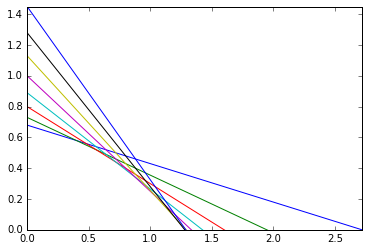

In [7]:
n = 8
c = [-1, -0.3*n]
A = [[100*i/n,100] for i in range(2,2+n)]
b = [i**2 + n**2 for i in range(2,2+n)]
plot(A, b)

([0.5599999999999996, 0.5200000000000002], -1.8080000000000003)

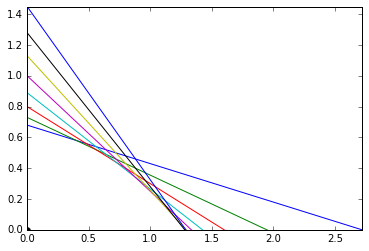

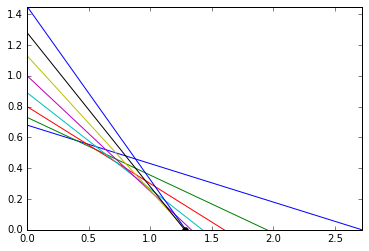

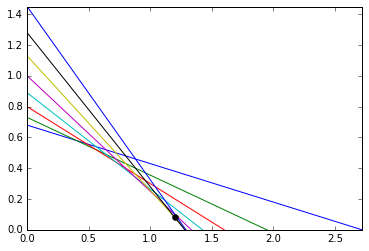

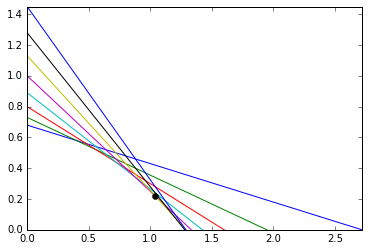

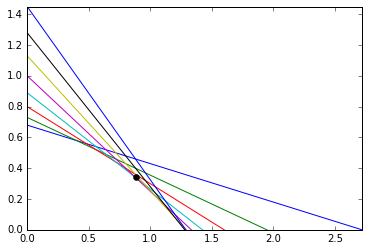

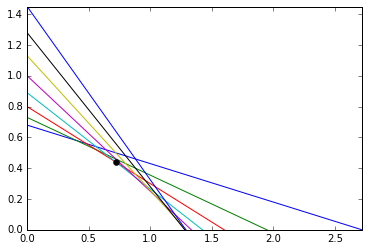

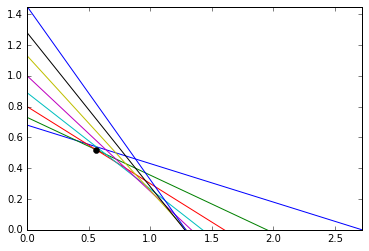

In [8]:
simplexe(c, A, b, dessinner=True)